# Estimating soil retention parameters
## M. Vanclooster 
## 27/02/18

In this $Python notebook$, we present a procedure to estimate the soil retention properties from laboratory data. We aim solving the following question: given a set of measured $\theta , h $ data, how can we estimate the properties of the van Genuchten soil moisture retention model.

Let's start first initialising our Python environment. 

In [211]:
# Miscellaneous operating system interfaces
import os
# Python Data Analysis library
import pandas as pd
# Python Numerical computating library
import numpy as np
# Python Scientifical computing library
import scipy as sc
# Python plotting library
from matplotlib import pyplot as plt

# Allowing plot inside the notebook
%matplotlib inline

Consider we've measured soil moisture retention data using standard soil physical techniques for seven different points (as for instance illustrated in the MOOC https://www.edx.org/course/leau-et-les-sols-hydrodynamique-des-louvainx-louv18x-0?source=aw&awc=6798_1519705641_b7725f30a0189508ae3ae8dbaf9e56db&utm_source=aw&utm_medium=affiliate_partner&utm_content=text-link&utm_term=301045_https://www.class-central.com/)

In [212]:
th_meas=np.array([0.4,0.38,0.37,0.25,0.18,0.14,0.11])
h_meas=np.array([1,10,100,199,600,1000,10000])

We visualise these data :

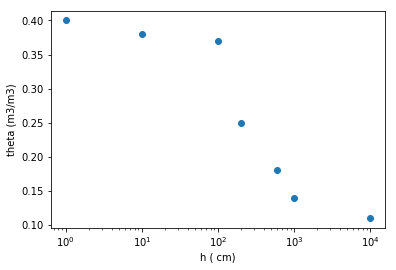

In [214]:
plt.semilogx(h_meas,th_meas,'o');
plt.xlabel('h ( cm)')
plt.ylabel('theta (m3/m3)')

We want to estimate the parameters of the van Genuchten equation, i.e.

\begin{equation}
\theta(h) =\theta_{r} +\frac{\theta_{s}-\theta_{r}}{(1+(\alpha h)^n)^m}
\end{equation}

that fits correctly these data.

Let's make an initial guess of these data and compare that to the observations:

In [231]:
thr = 0.10
ths = 0.4
alfa = 0.1
n = 1.3
m = 1-1/n

th_sim = thr+(ths-thr)/(1+(alfa*h_meas)**n)**(1-1/n)

We compare this graphically

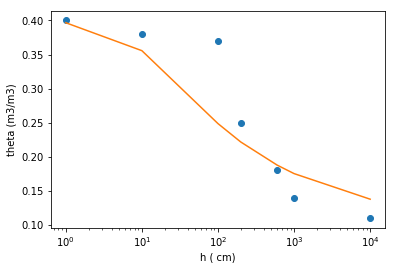

In [232]:
plt.semilogx(h_meas,th_meas,'o',h_meas,th_sim);
plt.xlabel('h ( cm)')
plt.ylabel('theta (m3/m3)')

Obviously, the model does not fit well the data. We could try to obtain better results, by modifying the parameters.  We can for instance fix the initial parameters, except n and, subsequently evaluate the retention model for different values of $n$. 

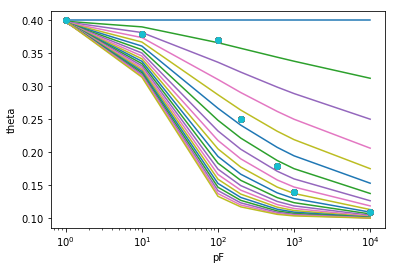

In [233]:
n_trial=np.arange(1, 2, 0.05)
th_trial=20*[0]

for i in range(0, 20):
    th_trial[i]=(thr+(ths-thr)/(1+(alfa*h_meas)**n_trial[i])**(1-1/n_trial[i]))
    plt.semilogx(h_meas,th_trial[i],h_meas,th_meas,'o');
    plt.xlabel('pF')
    plt.ylabel('theta')

Clearly, there are some values of $n$ that are more appropriate than the other ones. Yet the optimal value of n depends also on the value of $\alpha$, $\theta_{s}$ and $\theta_{r}$ that we have fixed. We should therefore not only change $n$, but also $\alpha$, $\theta_{s}$ and $\theta_{r}$, and for each possible combination, we should evaluate the quality of the simulation.

To do this more efficiently, we define an object function $OF$ in the least squares sense as follows:

\begin{equation}
OF(\theta_r ,\theta_s ,\alpha, n)=\sum{(\theta_{sim}\left(\theta_r, \theta_s, \alpha, n \right) - \theta_{obs}})^2
\end{equation}

This is a 4 dimensional object function in terms of $\theta_r ,\theta_s ,\alpha, n$. We consider that the optimal parameter vector $[\theta_r ,\theta_s ,\alpha, n]$ corresponds to the minimum of $OF$.

Let's start evaluating this function for different values of our parameters. To simplify calculations, we fix $\theta_s$ and $\theta_r$ to respectively the maximum and minimum observed values, and we evaluate the object function for 10 possible values of $\alpha$ and $n$ (so in total 100 evaluations of this object function).


In [249]:
thr=min(th_meas)
ths=max(th_meas)
n_trial=np.arange(1, 2, 0.1)
alfa_trial=np.arange(0,1,0.1)

th_sim=10*[0]
of=10*[0]

for i in range(0,10):
    th_sim[i]=10*[0]
    of[i]=10*[0]

for i in range(0,10):
    for j in range(0,10):
        th_sim [i] [j]=(thr+(ths-thr)/(1+(alfa_trial[j]*h_meas)**n_trial[i])**(1-1/n_trial[i]))
        of [i] [j]= sum((th_sim [i] [j]- th_meas)**2)

ind=np.asarray((res == min(min(of))).nonzero())      

We have evaluated the object function for each combination of $\alpha$ and $n$. This object function is coded in a two dimensional matrix, and we looked for the indices that correspond to the minimum value. We can visualise this object function for all possible combinations using a surfer plot:

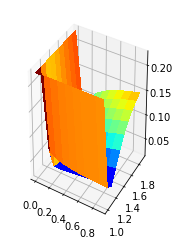

In [250]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = alfa_trial
Y = n_trial
X, Y = np.meshgrid(X, Y)
Z=np.asarray(of)

surf = ax.plot_surface(X, Y, Z, cmap=cm.jet,linewidth=0, antialiased=False)

We can evaluate the results for the optimal value of $\alpha$ and $n$.

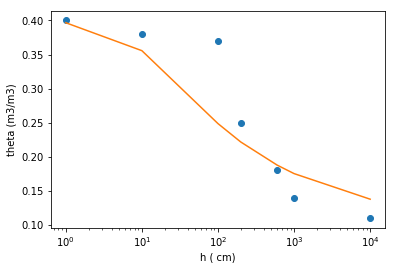

In [219]:
thr = 0.10
ths = 0.4
n_opt = n_trial[ind[0]]
alfa_opt = alfa_trial[ind[1]]
m = 1-1/n

th_sim = thr+(ths-thr)/(1+(alfa_opt*h_meas)**n_opt)**(1-1/n_opt)

plt.semilogx(h_meas,th_meas,'o',h_meas,th_sim);
plt.xlabel('h ( cm)')
plt.ylabel('theta (m3/m3)')

The optimal values that we obtain with this algorithm are as follows

In [220]:
n_opt

array([ 1.3])

In [221]:
alfa_opt

array([ 0.1])

These reults are good, but we can do much better. Actually, we only evaluated the object function for 100 values. We could also use statistical based optimisation approaches for obtaining the optimal parameters. The theoretical background will be explained in the class on inverse modelling. Here we anticipate already this by using a least square algorithm available in $scipy$ (i.e. a scientific calculation library in Python). We define the function that we would like to optimise:

In [251]:
def ret_model(h,alfa,n):
    return 0.1+(0.4-0.1)/(1+(alfa*h)**n)**(1-1/n)

Subsequently, we optimise the parameter using the $curvefit$ function in $scipy$.

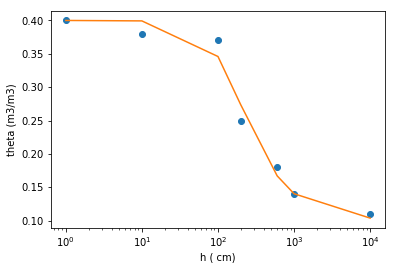

In [252]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(ret_model, h_meas, th_meas,  bounds=([0,1], [2., 5.]))

thr = 0.10
ths = 0.4
alfa_opt = popt[0]
n_opt = popt[1]
m = 1-1/n

th_sim = thr+(ths-thr)/(1+(alfa_opt*h_meas)**n_opt)**(1-1/n_opt)

plt.semilogx(h_meas,th_meas,'o',h_meas,th_sim);
plt.xlabel('h ( cm)')
plt.ylabel('theta (m3/m3)')

Our optimal parameters are therefore 

In [255]:
print ('alfa =', popt[0], 'n=', popt[1])

('alfa =', 0.0069590701165585791, 'n=', 2.0290029253142992)


The advantage of the automatic program is that we also can estimate the uncertainty associated with the parameter estimates. This is encoded in the covariance matrix: 

In [256]:
pcov

array([[  1.59573174e-06,  -2.09166150e-04],
       [ -2.09166150e-04,   4.51424018e-02]])